In [1]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
from random import random

# Independent Sampling

## Rejection Sampling

In [2]:
def rejection_sampling(xs_observed):
    i = 0
    while True:
        i += 1
        p = dist.Uniform(0,1).sample()
        xs = dist.Bernoulli(p).sample(xs_observed.shape)
        if (xs == xs_observed).all():
            return i, p

In [3]:
torch.manual_seed(0.)
xs = torch.tensor([0.,1.,1.,0.,0.])
posterior = dist.Beta(1 + xs.sum(), 1 + (1-xs).sum())

for i in range(len(xs)):
    xs_observed = xs[:(i+1)]
    N = 1000
    res = [rejection_sampling(xs_observed) for _ in range(N)]
    rejected = sum(i-1 for i,p in res)
    print(f"Rejected {rejected / (N+rejected)*100:.2f}% for {i+1} number of observations.")

Rejected 50.54% for 1 number of observations.
Rejected 83.78% for 2 number of observations.
Rejected 91.76% for 3 number of observations.
Rejected 96.68% for 4 number of observations.
Rejected 98.26% for 5 number of observations.


## Likelihood Weighting

In [4]:
x = torch.tensor([0.0, 0.5, 1.0, 1.5, 2.0]) - 1
y = torch.tensor([-1.2, -1.5, -0.0, -0.8, 1.5])

In [5]:
slope_prior = dist.Normal(0,3)
intercept_prior = dist.Normal(0,3)

In [6]:
torch.manual_seed(0)
N = 1000
slope_sample = slope_prior.sample((N,))
intercept_sample = intercept_prior.sample((N,))

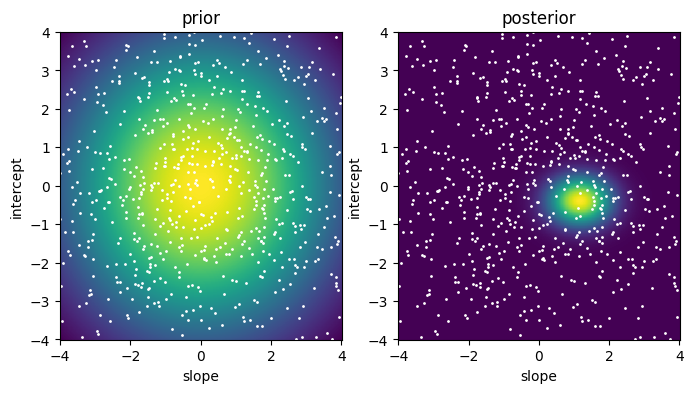

In [7]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
x_linspace = torch.linspace(x.min(),x.max(),10)
n_lines = 250

s = torch.linspace(-4,4,500)
i = torch.linspace(-4,4,500)
S, I = torch.meshgrid(s,i, indexing="ij")
S_flat = S.reshape(-1)
I_flat = I.reshape(-1)

prior = (slope_prior.log_prob(S) + intercept_prior.log_prob(I)).exp()

mask = (-4 < slope_sample) & (slope_sample < 4) & (-4 < intercept_sample) & (intercept_sample < 4)

axs[0].pcolormesh(S,I,prior)
axs[0].scatter(slope_sample[mask], intercept_sample[mask], color="white", s=1)
axs[0].set_xlabel("slope")
axs[0].set_ylabel("intercept")
axs[0].set_title("prior")

Y = S.reshape(*S.shape, 1) * x.reshape(1,1,-1) + I.reshape(*S.shape, 1)
unnormalised_posterior = (dist.Normal(Y, 1.).log_prob(y.reshape(1,1,-1)).sum(dim=2) + slope_prior.log_prob(S) + intercept_prior.log_prob(I)).exp()


axs[1].pcolormesh(S,I,unnormalised_posterior)
axs[1].scatter(slope_sample[mask], intercept_sample[mask], color="white", s=1)
axs[1].set_xlabel("slope")
axs[1].set_ylabel("intercept")
axs[1].set_title("posterior")

plt.savefig("lecture_3_figs/likelihood_disadvantage.png")

# Dependent Sampling

In [8]:
def linreg_mh(x0, n_iter):
    result = []
    current = x0
    for i in range(n_iter):
        P_current = (
            dist.Normal(current[0] * x + current[1], torch.tensor(1.)).log_prob(y).sum() + 
            dist.Normal(0.,3.).log_prob(current).sum()
        ).exp()
        proposed = dist.Normal(current, torch.tensor(0.5)).sample()
        P_proposed = (
            dist.Normal(proposed[0] * x + proposed[1], torch.tensor(1.)).log_prob(y).sum() + 
            dist.Normal(0.,3.).log_prob(proposed).sum()
        ).exp()
        
        A = P_proposed/P_current
        
        if torch.rand(()) < A:
            current = proposed
        result.append(current)
    
    return torch.vstack(result)

In [9]:
torch.manual_seed(0)
x0 = torch.tensor([-4.,3.])
result = linreg_mh(x0, 1000)

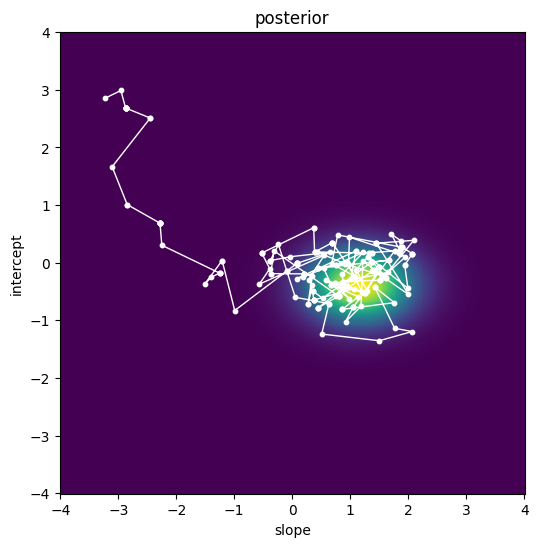

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.pcolormesh(S,I,unnormalised_posterior)
ax.scatter(result[:200,0], result[:200,1], color="white", s=10)
ax.plot(result[:200,0], result[:200,1], color="white", linewidth=1)
ax.set_xlabel("slope")
ax.set_ylabel("intercept")
ax.set_title("posterior")
plt.savefig("lecture_3_figs/dependent_motivation.png")

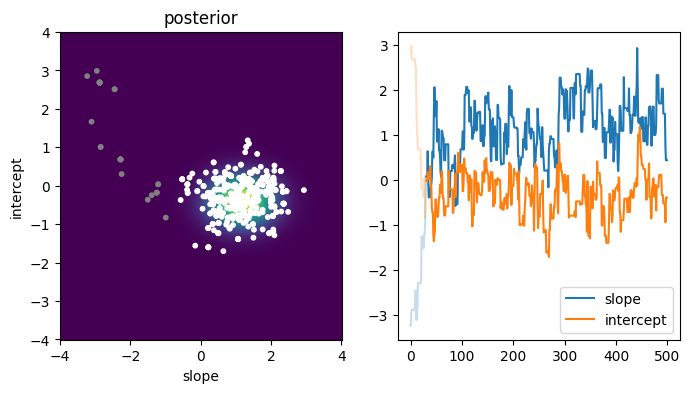

In [11]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].pcolormesh(S,I,unnormalised_posterior)
N = 500
burnin = 30
color = ["white" if i > burnin else "gray" for i in range(N)]
axs[0].scatter(result[:N,0], result[:N,1], color=color, s=10)
#axs[0].plot(result[burnin:N,0], result[burnin:N,1], color="white", linewidth=1)
axs[0].set_xlabel("slope")
axs[0].set_ylabel("intercept")
axs[0].set_title("posterior")

axs[1].plot(range(burnin), result[:burnin,0], alpha=0.25, color="tab:blue")
axs[1].plot(range(burnin,N), result[burnin:N,0], alpha=1., color="tab:blue", label="slope")
axs[1].plot(range(burnin), result[:burnin,1], alpha=0.25, color="tab:orange")
axs[1].plot(range(burnin,N), result[burnin:N,1], alpha=1., color="tab:orange", label="intercept")

plt.legend()

plt.show()
#plt.savefig("lecture_3_figs/mh_burnin.png")

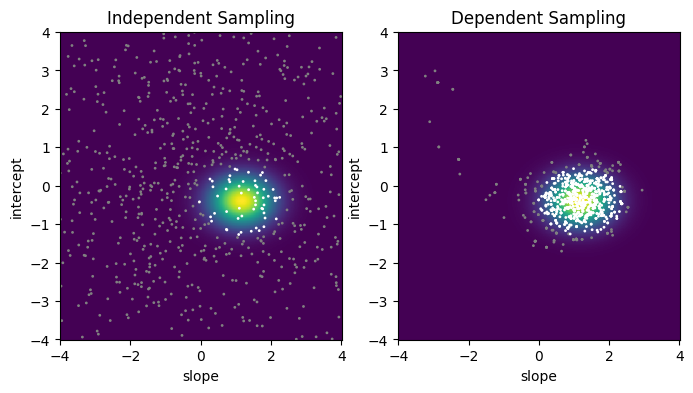

In [12]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
x_linspace = torch.linspace(x.min(),x.max(),10)
n_lines = 250

axs[0].pcolormesh(S,I,unnormalised_posterior)
l = dist.Normal(
    slope_sample[mask].reshape(-1,1) * x.reshape(1,-1) + intercept_sample[mask].reshape(-1,1),
    torch.tensor(1.)
    ).log_prob(y.reshape(1,-1)).sum(dim=1).exp()
color = ["gray" if l[i] < 0.0005 else "white" for i in range(len(l))]
axs[0].scatter(slope_sample[mask], intercept_sample[mask], color=color, s=1)
axs[0].set_xlabel("slope")
axs[0].set_ylabel("intercept")
axs[0].set_title("Independent Sampling")


axs[1].pcolormesh(S,I,unnormalised_posterior)
l = dist.Normal(
    result[:,0].reshape(-1,1) * x.reshape(1,-1) + result[:,1].reshape(-1,1),
    torch.tensor(1.)
    ).log_prob(y.reshape(1,-1)).sum(dim=1).exp()
color = ["gray" if l[i] < 0.0005 else "white" for i in range(len(l))]
axs[1].scatter(result[:,0], result[:,1], color=color, s=1)
#ax.plot(result[:,0], result[:,1], color="white", linewidth=1)
axs[1].set_xlabel("slope")
axs[1].set_ylabel("intercept")
axs[1].set_title("Dependent Sampling")
plt.savefig("lecture_3_figs/independent_vs_dependent.png")

## Metroplis Hastings

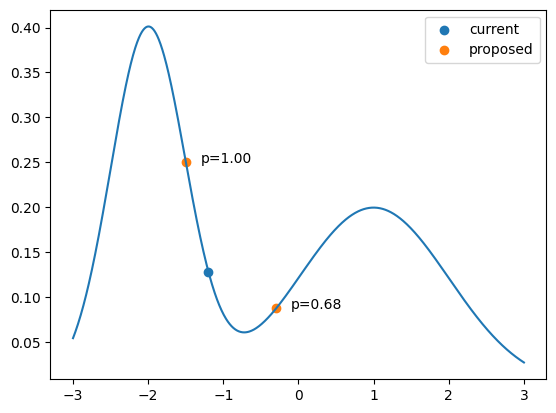

In [13]:
xs = torch.linspace(-3,3,1000)
def f(xs):
    return 0.5 * dist.Normal(-2,0.5).log_prob(xs).exp() + 0.5 * dist.Normal(1.,1.).log_prob(xs).exp()
fs = f(xs)
plt.plot(xs, fs)
i = 300
plt.scatter([xs[i]], [fs[i]], label="current")
i1 = 250
i2 = 450
plt.scatter([xs[i1], xs[i2]], [fs[i1], fs[i2]], label="proposed")
plt.annotate(f"p={min(fs[i1]/fs[i],1):.2f}", (xs[i1]+0.2, fs[i1]))
plt.annotate(f"p={min(fs[i2]/fs[i],1):.2f}", (xs[i2]+0.2, fs[i2]))
plt.legend()
plt.savefig("lecture_3_figs/hill_climbing.png")

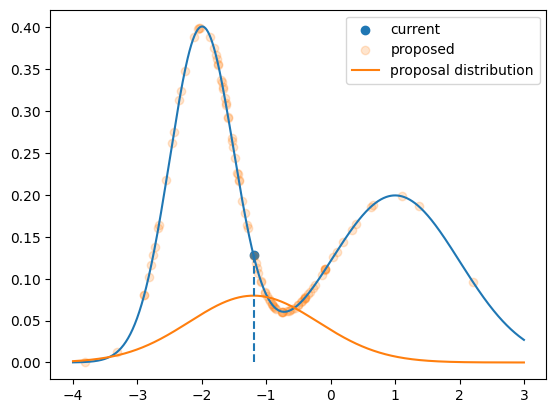

In [14]:
xs = torch.linspace(-4,3,1000)
fs = f(xs)
plt.plot(xs, fs)
i = 400
plt.scatter([xs[i]], [fs[i]], label="current")
torch.manual_seed(0)
sigma = 1.
proposed = dist.Normal(xs[i],sigma).sample((100,))
f_proposed = f(proposed)

plt.scatter(proposed, f_proposed, label="proposed", alpha=0.2)
plt.plot(xs, dist.Normal(xs[i],sigma).log_prob(xs).exp() / 5, label="proposal distribution")
plt.vlines(xs[i], 0., fs[i], linestyles="dashed")
plt.legend()
plt.savefig("lecture_3_figs/gaussian_proposal_1.png")

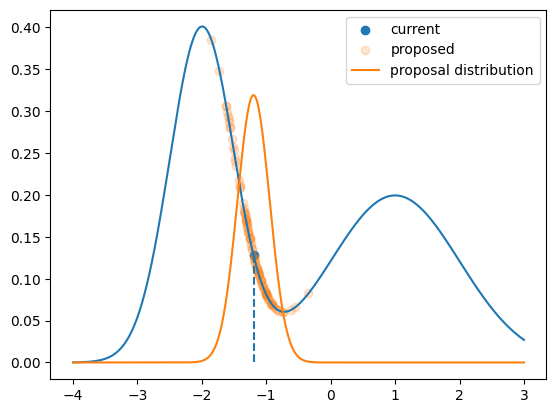

In [15]:
xs = torch.linspace(-4,3,1000)
fs = f(xs)
plt.plot(xs, fs)
i = 400
plt.scatter([xs[i]], [fs[i]], label="current")
torch.manual_seed(0)
sigma = 0.25
proposed = dist.Normal(xs[i],sigma).sample((100,))
f_proposed = f(proposed)

plt.scatter(proposed, f_proposed, label="proposed", alpha=0.2)
plt.plot(xs, dist.Normal(xs[i],sigma).log_prob(xs).exp() / 5, label="proposal distribution")
plt.vlines(xs[i], 0., fs[i], linestyles="dashed")
plt.legend()
plt.savefig("lecture_3_figs/gaussian_proposal_2.png")

In [16]:
def get_P(a,b):
    def P(x):
        return 0.5 * dist.Normal(a ,0.5).log_prob(x).exp() + 0.5 * dist.Normal(b,1.).log_prob(x).exp()
    return P

def mh(P, x0, n_iter, sigma):
    result = []
    current = x0
    for i in range(n_iter):
        P_current = P(current)
        proposed = dist.Normal(current, sigma).sample()
        P_proposed = P(proposed)
        
        A = P_proposed/P_current
        
        if torch.rand(()) < A:
            current = proposed
        result.append(current)
    
    return torch.hstack(result)

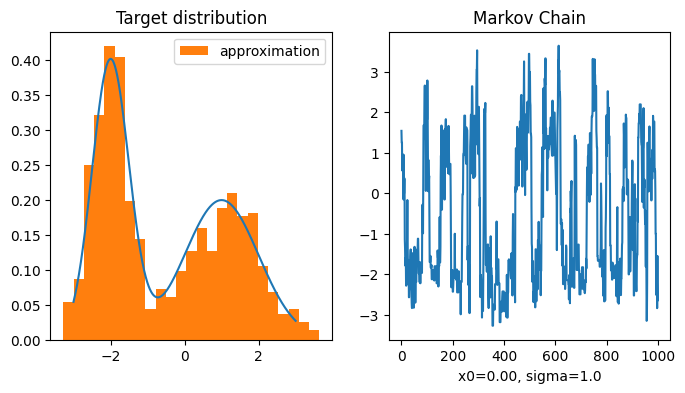

In [17]:
def plot_mh(a,b, xlim, x0, sigma, n_iter, bins):
    torch.manual_seed(0)
    fig, axs = plt.subplots(1,2,figsize=(8,4))
    xs = torch.linspace(*xlim,1000)
    P = get_P(a,b)
    axs[0].plot(xs, P(xs))
    axs[0].set_title("Target distribution")

    chain = mh(P, x0, n_iter, sigma)
    axs[1].plot(chain)
    axs[1].set_title("Markov Chain")
    axs[1].set_xlabel(f"x0={x0:.2f}, sigma={sigma}")
    axs[0].hist(chain,density=True,bins=bins,label="approximation")
    axs[0].legend()
    
plot_mh(
    a = -2, b = 1,
    xlim = (-3,3),
    x0 = torch.tensor(0.0),
    sigma = 1.,
    n_iter = 1000,
    bins =25
)
plt.savefig("lecture_3_figs/mh_1.png")

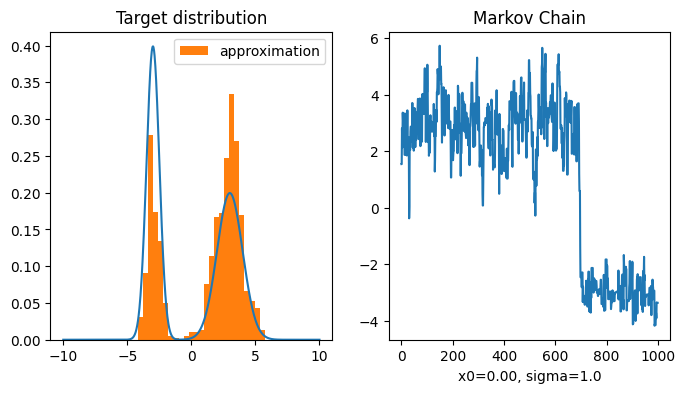

In [18]:
plot_mh(
    a = -3, b = 3,
    xlim=  (-10,10),
    x0 = torch.tensor(0.0),
    sigma = 1.,
    n_iter = 1000,
    bins = 25
)
plt.savefig("lecture_3_figs/mh_2.png")

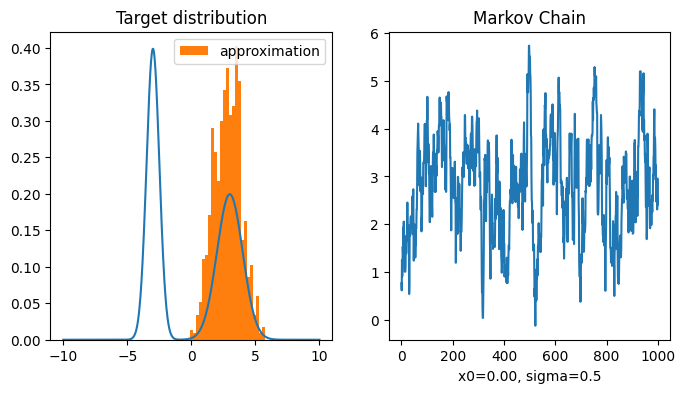

In [19]:
plot_mh(
    a = -3, b = 3,
    xlim=  (-10,10),
    x0 = torch.tensor(0.0),
    sigma = 0.5,
    n_iter = 1000,
    bins = 25
)
plt.savefig("lecture_3_figs/mh_3.png")

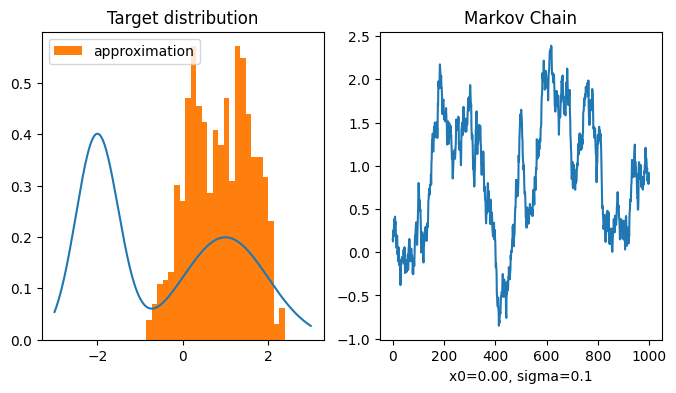

In [20]:
plot_mh(
    a = -2, b = 1,
    xlim = (-3,3),
    x0 = torch.tensor(0.0),
    sigma = 0.1,
    n_iter = 1000,
    bins = 25
)
plt.savefig("lecture_3_figs/mh_4.png")

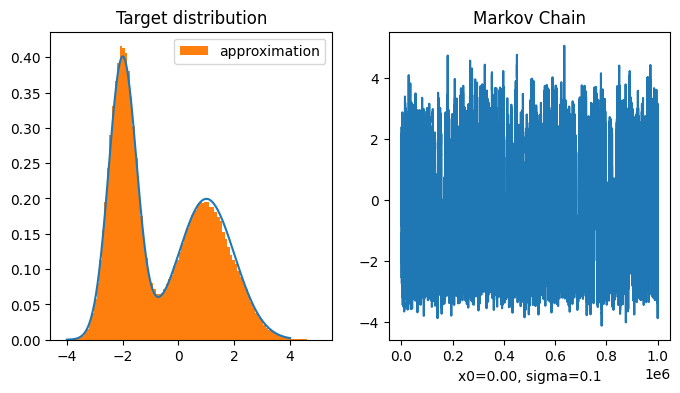

In [21]:
plot_mh(
    a = -2, b = 1,
    xlim = (-4,4),
    x0 = torch.tensor(0.0),
    sigma = 0.1,
    n_iter = 1000000,
    bins = 100
)
plt.savefig("lecture_3_figs/mh_5.png")

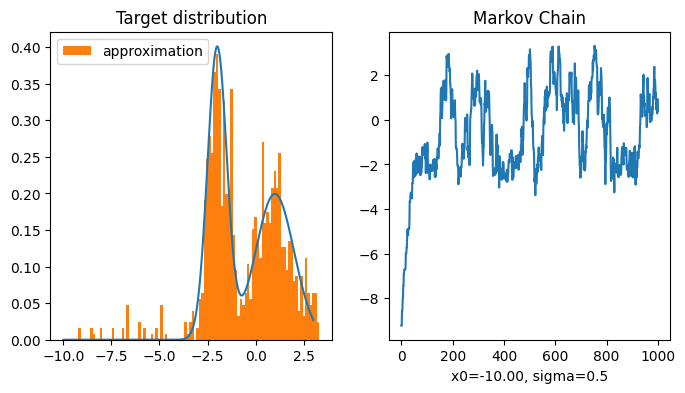

In [22]:
plot_mh(
    a = -2, b = 1,
    xlim = (-10,3),
    x0 = torch.tensor(-10.),
    sigma = 0.5,
    n_iter = 1000,
    bins = 100
)
plt.savefig("lecture_3_figs/mh_6.png")

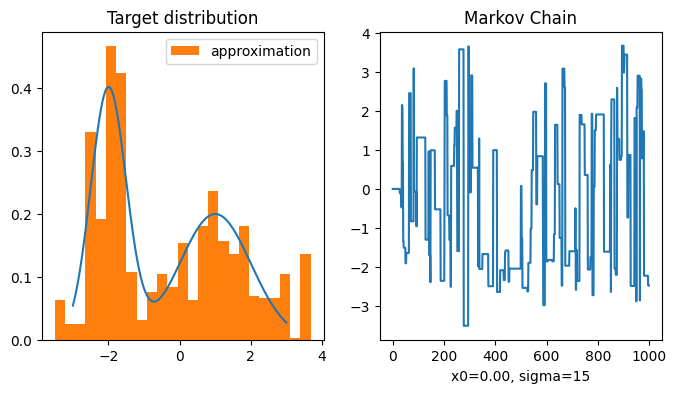

In [23]:
plot_mh(
    a = -2, b = 1,
    xlim = (-3,3),
    x0 = torch.tensor(0.),
    sigma = 15,
    n_iter = 1000,
    bins = 25
)
plt.savefig("lecture_3_figs/mh_7.png")

### Stationary Distribution

In [24]:
def T(x, P, sigma):
    P_current = P(x)
    proposed = dist.Normal(x, sigma).sample()
    P_proposed = P(proposed)

    A = P_proposed/P_current

    if torch.rand(()) < A:
        y = proposed
    else:
        y = x

    return y

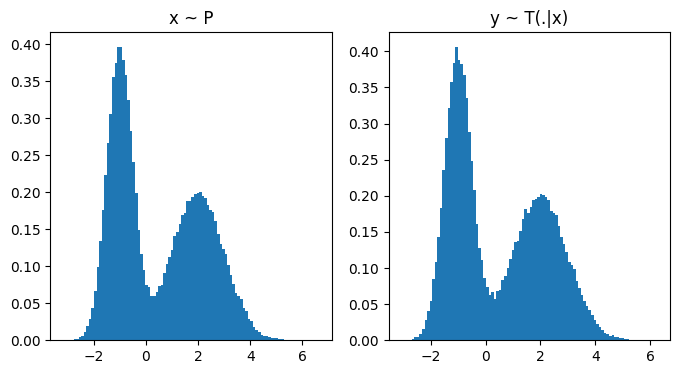

In [25]:
def sample_P(a,b,n):
    X1 = dist.Normal(a,0.5).sample((n,))
    X2 = dist.Normal(b, 1.).sample((n,))
    Z = dist.Bernoulli(0.5).sample((n,)).bool()
    X = X1
    X[Z] = X2[Z]
    return X

fig, axs = plt.subplots(1,2,figsize=(8,4))
torch.manual_seed(0)
X = sample_P(-1,2,100000)
axs[0].hist(X,bins=100,density=True)
axs[0].set_title("x ~ P")

Y = torch.tensor([T(x, get_P(-1,2), 0.5) for x in X])
axs[1].hist(Y,bins=100,density=True)
axs[1].set_title("y ~ T(.|x)")
plt.savefig("lecture_3_figs/detailed_balance.png")

## Metroplis Hastings For PPL

In [26]:
x = torch.tensor([0.0, 0.5, 1.0, 1.5, 2.0]) - 1
y = torch.tensor([-1.2, -1.5, -0.0, -0.8, 1.5])

In [27]:
def linreg_single_site_mh(x0, n_iter):
    result = []
    current = x0
    for i in range(n_iter):
        P_current = (
            dist.Normal(current[0] * x + current[1], torch.tensor(1.)).log_prob(y).sum() + 
            dist.Normal(0.,3.).log_prob(current).sum()
        ).exp()
        delta = dist.Normal(torch.tensor(0.), torch.tensor(0.5)).sample()
        proposed = current.clone()
        if torch.rand(()) < 0.5:
            # update first parameter
            proposed[0] += delta
        else:
            # update second parameter
            proposed[1] += delta
        P_proposed = (
            dist.Normal(proposed[0] * x + proposed[1], torch.tensor(1.)).log_prob(y).sum() + 
            dist.Normal(0.,3.).log_prob(proposed).sum()
        ).exp()
        
        A = P_proposed/P_current
        
        if torch.rand(()) < A:
            current = proposed
        result.append(current)
    
    return torch.vstack(result)

In [28]:
torch.manual_seed(0)
x0 = torch.tensor([-4.,3.])
result = linreg_single_site_mh(x0, 1000)

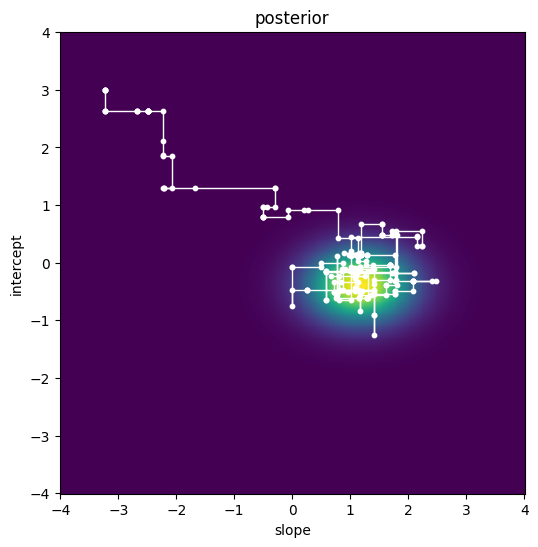

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.pcolormesh(S,I,unnormalised_posterior)
ax.scatter(result[:200,0], result[:200,1], color="white", s=10)
ax.plot(result[:200,0], result[:200,1], color="white", linewidth=1)
ax.set_xlabel("slope")
ax.set_ylabel("intercept")
ax.set_title("posterior")
plt.savefig("lecture_3_figs/linreg_singlesite_mh.png")

In [30]:
import torch
from typing import Optional

_SAMPLE_CONTEXT = None

class SampleContext:
    # start of with block
    def __enter__(self):
        global _SAMPLE_CONTEXT
        _SAMPLE_CONTEXT = self

    # end of with block
    def __exit__(self, *args):
        global _SAMPLE_CONTEXT
        _SAMPLE_CONTEXT = None
        
    def sample(self, address: str, distribution: dist.Distribution, observed: Optional[torch.Tensor] = None) -> torch.Tensor:
        raise NotImplementedError


def sample(address: str, distribution: dist.Distribution, observed: Optional[torch.Tensor] = None) -> torch.Tensor:
    global _SAMPLE_CONTEXT
    
    # default behavior
    if _SAMPLE_CONTEXT is None:
        if observed is not None:
            return observed
        return distribution.sample()
    
    # context specific behavior
    return _SAMPLE_CONTEXT.sample(address, distribution, observed)

In [31]:
class Trace(SampleContext):
    def __init__(self):
        self.trace = {}

    def sample(self,
               address: str,
               distribution: dist.Distribution,
               observed: Optional[torch.Tensor] = None) -> torch.Tensor:
               
        if observed is not None:
            value = observed
        else:
            value = distribution.sample()
            
        self.trace[address] = {
            'value': value,
            'distribution': distribution,
            'is_observed': observed is not None,
            'log_prob': distribution.log_prob(value)
        }
        
        return value

In [32]:
def noisy_geometric(p):
    x = 0
    while True:
        b = sample(f"b_{x}", dist.Bernoulli(p))
        if b:
            break
        x += 1
    y = sample("y", dist.Normal(x,1), observed=torch.tensor(3))
    return x

In [33]:
torch.manual_seed(0)
[noisy_geometric(0.25) for _ in range(10)]

[2, 0, 8, 0, 4, 8, 0, 3, 1, 0]

In [34]:
torch.manual_seed(0)
ctx = Trace()
with ctx:
    x = noisy_geometric(0.25)
ctx.trace 

{'b_0': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-0.2877)},
 'b_1': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-0.2877)},
 'b_2': {'value': tensor(1.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-1.3863)},
 'y': {'value': tensor(3),
  'distribution': Normal(loc: 2.0, scale: 1.0),
  'is_observed': True,
  'log_prob': tensor(-1.4189)}}

In [35]:
torch.manual_seed(1)
ctx = Trace()
with ctx:
    x = noisy_geometric(0.25)
ctx.trace 

{'b_0': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-0.2877)},
 'b_1': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-0.2877)},
 'b_2': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-0.2877)},
 'b_3': {'value': tensor(0.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-0.2877)},
 'b_4': {'value': tensor(1.),
  'distribution': Bernoulli(probs: 0.25, logits: -1.0986123085021973),
  'is_observed': False,
  'log_prob': tensor(-1.3863)},
 'y': {'value': tensor(3),
  'distribution': Normal(loc: 4.0, scale: 1.0),
  'is_observed': True,
  'log_prob': tensor(-1.4189)}}

In [36]:
def model():
    X = sample("X", dist.Normal(0,1))
    Y = sample("Y", dist.Normal(X,1))
    if Y < 0:
        sample("A", dist.Normal(0,1), observed=torch.tensor(1.))
    else:
        sample("B", dist.Normal(0,1))

In [37]:
torch.manual_seed(0)
ctx = Trace()
with ctx:
    model()
ctx.trace 

{'X': {'value': tensor(1.5410),
  'distribution': Normal(loc: 0.0, scale: 1.0),
  'is_observed': False,
  'log_prob': tensor(-2.1063)},
 'Y': {'value': tensor(1.2476),
  'distribution': Normal(loc: 1.5409960746765137, scale: 1.0),
  'is_observed': False,
  'log_prob': tensor(-0.9620)},
 'B': {'value': tensor(-2.1788),
  'distribution': Normal(loc: 0.0, scale: 1.0),
  'is_observed': False,
  'log_prob': tensor(-3.2925)}}

In [38]:
x = torch.tensor([0.0, 0.5, 1.0, 1.5, 2.0]) - 1
y = torch.tensor([-1.2, -1.5, -0.0, -0.8, 1.5])

def linear_regression(x, y):
    slope = sample("slope", dist.Normal(0,3))
    intercept = sample("intercept", dist.Normal(0,3))
    for i in range(len(x)):
        sample(f"y_{i}", dist.Normal(slope*x[i]+intercept, 1.), observed=y[i])

In [39]:
torch.manual_seed(0)
ctx = Trace()
with ctx:
    linear_regression(x,y)
ctx.trace 

{'slope': {'value': tensor(4.6230),
  'distribution': Normal(loc: 0.0, scale: 3.0),
  'is_observed': False,
  'log_prob': tensor(-3.2049)},
 'intercept': {'value': tensor(-0.8803),
  'distribution': Normal(loc: 0.0, scale: 3.0),
  'is_observed': False,
  'log_prob': tensor(-2.0606)},
 'y_0': {'value': tensor(-1.2000),
  'distribution': Normal(loc: -5.503274917602539, scale: 1.0),
  'is_observed': True,
  'log_prob': tensor(-10.1780)},
 'y_1': {'value': tensor(-1.5000),
  'distribution': Normal(loc: -3.1917808055877686, scale: 1.0),
  'is_observed': True,
  'log_prob': tensor(-2.3500)},
 'y_2': {'value': tensor(-0.),
  'distribution': Normal(loc: -0.880286693572998, scale: 1.0),
  'is_observed': True,
  'log_prob': tensor(-1.3064)},
 'y_3': {'value': tensor(-0.8000),
  'distribution': Normal(loc: 1.4312074184417725, scale: 1.0),
  'is_observed': True,
  'log_prob': tensor(-3.4081)},
 'y_4': {'value': tensor(1.5000),
  'distribution': Normal(loc: 3.742701530456543, scale: 1.0),
  'is_obs

## Hamiltionan Monte Carlo

In [40]:
def hmc_trajectory(x, p, eps, L):
    def grad_U(x):
        x = x.clone().requires_grad_(True)
        u = - torch.log(banana(x[0], x[1]))
        u.backward()
        return x.grad
    
    traj = [x]
    X = x
    R = p
    
    R = R - eps/2 * grad_U(x)
    for _ in range(L-1):
        X = X + eps * R
        R = R - eps * grad_U(X)
        traj.append(X)
    X = X + eps * R
    traj.append(X)
    R = R - eps/2 * grad_U(X)
    return torch.vstack(traj), X, -R

In [41]:
def banana(x,y):
    lp = dist.Normal(0.,1.).log_prob(x)
    lp += dist.Normal(3-2*x**2,1.).log_prob(y)
    return lp.exp()

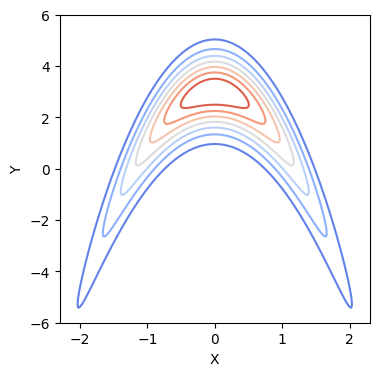

In [42]:
from matplotlib import cm

xs = torch.linspace(-2.3,2.3,200)
ys = torch.linspace(-6,6,200)     

fig, ax = plt.subplots(1,1,figsize=(4,4))
X, Y = torch.meshgrid(xs, ys, indexing="ij")
ax.contour(X, Y, banana(X, Y), cmap=cm.coolwarm)
ax.set_xlabel("X")
ax.set_ylabel("Y")
#plt.savefig("potential_2.png")
plt.show()

(tensor(4.0879), tensor(4.1325))

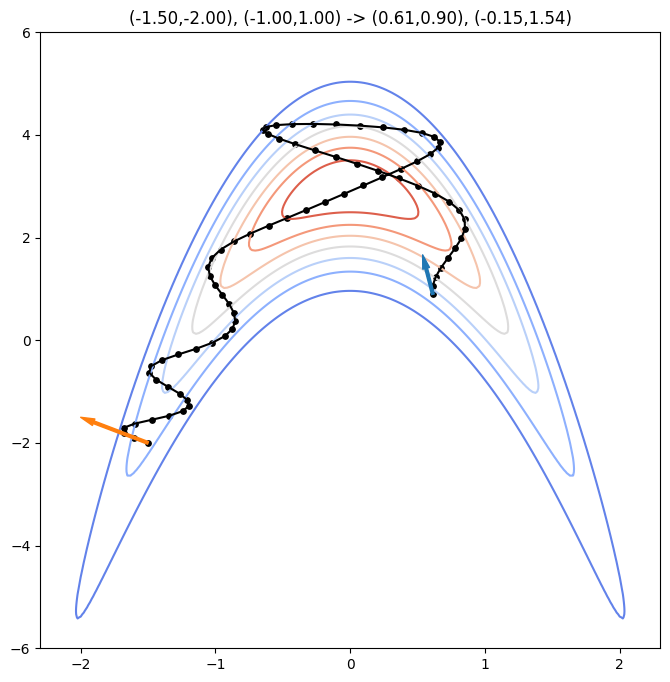

In [43]:
x = torch.tensor([-1.5,-2])
p = torch.tensor([-1,1])
H = -torch.log(banana(x[0],x[1])) + p.dot(p)/2
traj, x_new, p_new = hmc_trajectory(x, p, 0.1, 75)
H_new = -torch.log(banana(x_new[0],x_new[1])) + p_new.dot(p_new)/2

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.contour(X, Y, banana(X, Y), cmap=cm.coolwarm)
ax.scatter(traj[:,0], traj[:,1],s=15,c="black")
ax.plot(traj[:,0], traj[:,1],c="black")
ax.annotate("", xy=(x[0]+p[0]/2,x[1]+p[1]/2), xytext=(x[0],x[1]), arrowprops={"width":2,"headwidth":5.,'headlength':10.,'color':'tab:orange'})
ax.annotate("", xy=(x_new[0]+p_new[0]/2,x_new[1]+p_new[1]/2), xytext=(x_new[0],x_new[1]), arrowprops={"width":2,"headwidth":5.,'headlength':10.,'color':'tab:blue'})
ax.set_title(f"({x[0]:.2f},{x[1]:.2f}), ({p[0]:.2f},{p[1]:.2f}) -> ({x_new[0]:.2f},{x_new[1]:.2f}), ({p_new[0]:.2f},{p_new[1]:.2f})")
plt.savefig("lecture_3_figs/hmc_trajectory.png")
H, H_new

(tensor([-1.5000, -2.0000]), tensor([-1.0000,  1.0000]))

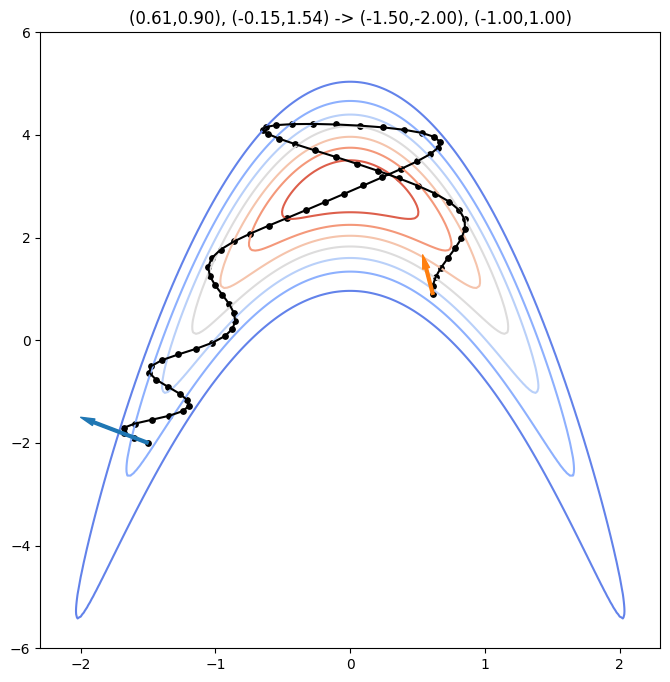

In [44]:
x = x_new
p = p_new
traj, x_new, p_new = hmc_trajectory(x, p, 0.1, 75)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.contour(X, Y, banana(X, Y), cmap=cm.coolwarm)
ax.scatter(traj[:,0], traj[:,1],s=15,c="black")
ax.plot(traj[:,0], traj[:,1],c="black")
ax.annotate("", xy=(x[0]+p[0]/2,x[1]+p[1]/2), xytext=(x[0],x[1]), arrowprops={"width":2,"headwidth":5.,'headlength':10.,'color':'tab:orange'})
ax.annotate("", xy=(x_new[0]+p_new[0]/2,x_new[1]+p_new[1]/2), xytext=(x_new[0],x_new[1]), arrowprops={"width":2,"headwidth":5.,'headlength':10.,'color':'tab:blue'})
ax.set_title(f"({x[0]:.2f},{x[1]:.2f}), ({p[0]:.2f},{p[1]:.2f}) -> ({x_new[0]:.2f},{x_new[1]:.2f}), ({p_new[0]:.2f},{p_new[1]:.2f})")
plt.savefig("lecture_3_figs/hmc_trajectory_reversed.png")
x_new, p_new